# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from timeit import default_timer as timer

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)


# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means++' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [3]:
__metaclass__ = type


class MyKmeans:
    def __rand_init(self, X):
        self.centroids = X[np.random.choice(X.shape[0],
                           size=self.k, replace=False)]

    def __kmeanspp_init(self, X):
        self.centroids[0] = X[np.random.choice(X.shape[0])]
        for i in xrange(1, self.k):
            dists = self.dist(X, self.centroids[:i, :]).min(axis=1)
            weights = dists / dists.sum()
            self.centroids[i] = X[np.random.choice(X.shape[0], p=weights)]

    @staticmethod
    def __euclidean_metric(X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        dist = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        dist[dist < 0] = 0
        return np.sqrt(dist)

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', eps=0.1):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        if init == 'random':
            self.init_centroids = self.__rand_init
        else:
            self.init_centroids = self.__kmeanspp_init
        self.dist = self.__euclidean_metric
        self.eps = eps

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        X = X.astype(float)

        self.init_centroids(X)

        for _ in xrange(self.max_iter):
            self.labels = self.dist(X, self.centroids).argmin(axis=1)
            new_centroids = np.empty((self.k, X.shape[1]))
            for i in xrange(self.k):
                if np.any(self.labels == i):
                    new_centroids[i] = np.mean(X[self.labels == i], axis=0)
                else:
                    new_centroids[i] = X[np.random.choice(X.shape[0])]
            if np.all(np.abs(new_centroids - self.centroids) < self.eps):
                break
            self.centroids = np.copy(new_centroids)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """

        return self.dist(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', eps=0.1, n_batches=10):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :n_batches - количество батчей
        """

        super(MiniBatchKMeans, self)\
            .__init__(k=k, metric=metric, max_iter=max_iter,
                      random_state=random_state, init=init, eps=eps)
        self.n_batches = n_batches

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        X = X.astype(float)

        self.init_centroids(X)

        v = np.zeros(self.k)
        for _ in xrange(self.max_iter):
            M = X[np.random.choice(X.shape[0],
                                   size=min(self.n_batches, X.shape[0]),
                                   replace=False)]
            self.labels = self.dist(M, self.centroids).argmin(axis=1)
            new_centroids = np.copy(self.centroids)
            for i in xrange(M.shape[0]):
                c = self.labels[i]
                v[c] += 1
                eta = 1 / v[c]
                new_centroids[c] = (1 - eta) * new_centroids[c] + eta * M[i]
            if np.all(np.abs(new_centroids - self.centroids) < self.eps):
                break
            self.centroids = np.copy(new_centroids)
        self.labels = self.dist(X, self.centroids).argmin(axis=1)

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs


In [5]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1,
                  center_box=(-10.0, 10.0), shuffle=False, random_state=1234)


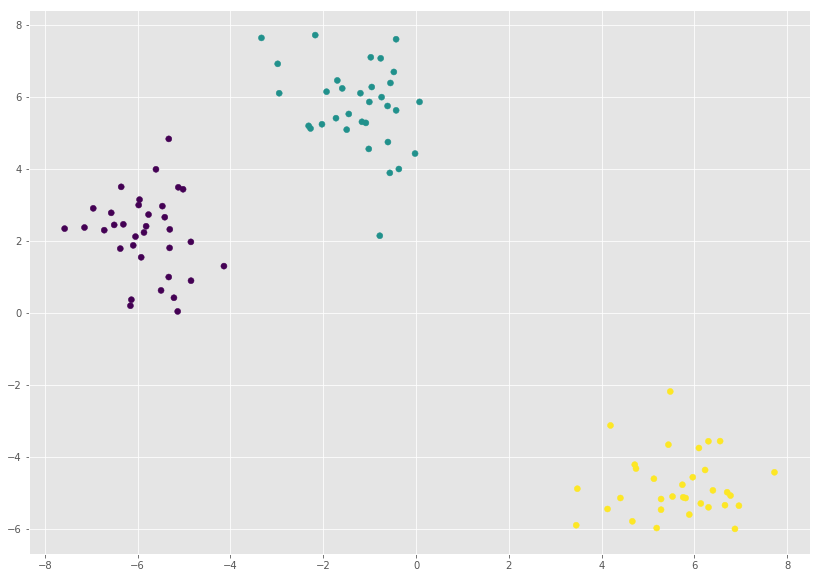

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)


Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [7]:
def check_model(model):
    labels = model.fit(X).labels

    color_map = {}
    for i in xrange(X.shape[0]):
        if y[i] not in color_map:
            color_map[y[i]] = labels[i]
        elif color_map[y[i]] != labels[i]:
            raise ValueError('Incorrect')
    print 'Correct'

    for centroid in model.centroids:
        plt.scatter(centroid[0], centroid[1], s=2000)
    plt.scatter(X[:, 0], X[:, 1], c=y)


Correct


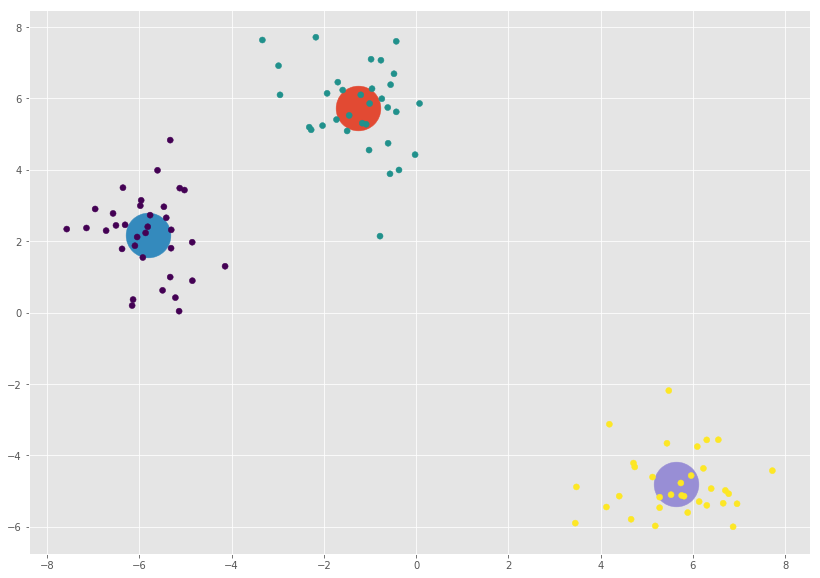

In [8]:
# Работоспособность MyKmeans
check_model(MyKmeans(k=3, random_state=1234))


Correct


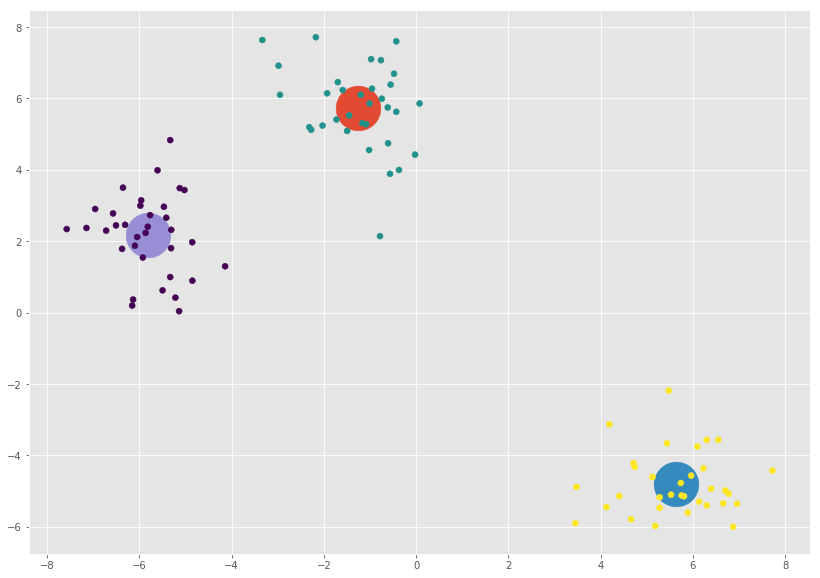

In [9]:
# Работоспособность MyKmeans++
check_model(MyKmeans(k=3, init='k_means++', random_state=1234))


Correct


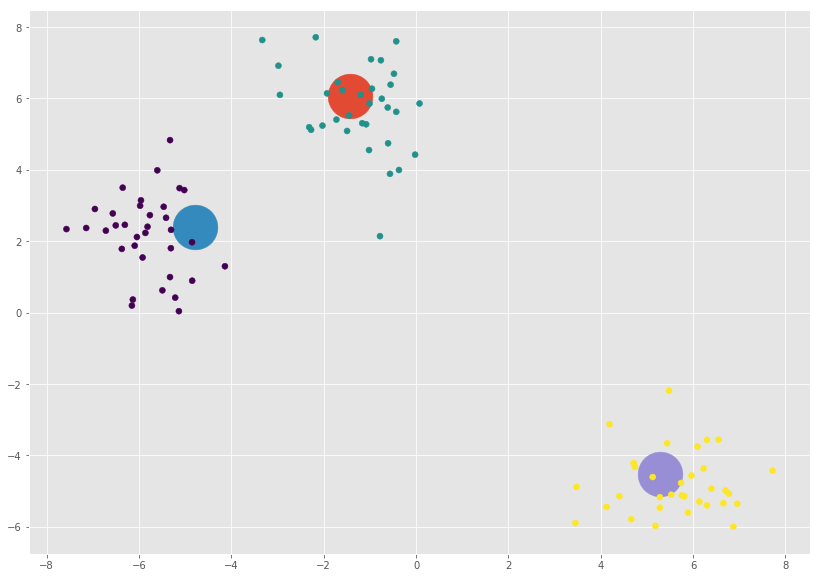

In [10]:
# Работоспособность MyKmeans с MiniBatchMyKmeans
check_model(MiniBatchKMeans(k=3, random_state=1234, n_batches=10))


Correct


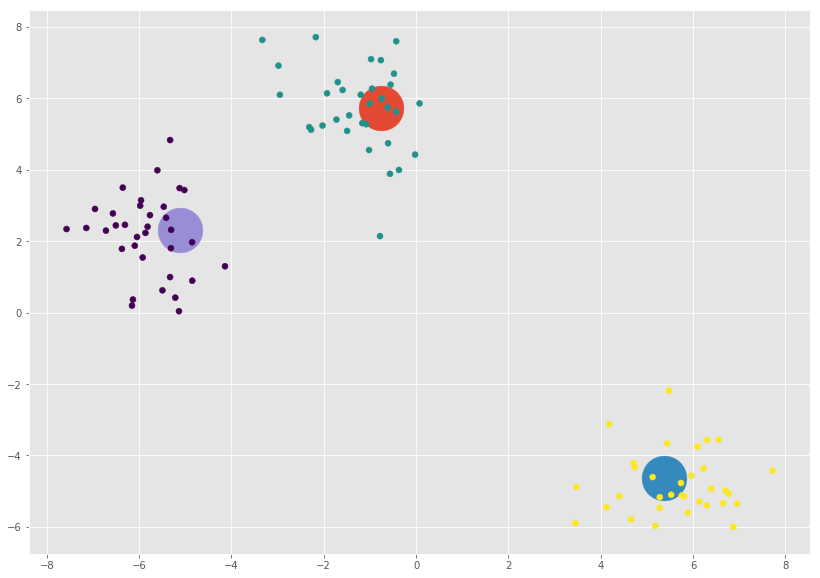

In [11]:
# Работоспособность MyKmeans++ с MiniBatchMyKmeans
check_model(MiniBatchKMeans(k=3, init='k_means++',
                            random_state=1234, n_batches=10))


In [12]:
# Время выполнения алгоритма Kmeans из sklearn
model = KMeans(n_clusters=3, max_iter=100)
%timeit model.fit(X)


10 loops, best of 3: 29 ms per loop


In [13]:
# Время выполнения алгоритма MyKmeans
model = MyKmeans(k=3, max_iter=100)
%timeit model.fit(X)


1000 loops, best of 3: 1.36 ms per loop


In [14]:
# Время выполнения алгоритма MyKmeans++
model = MyKmeans(k=3, init='k_means++', max_iter=100)
%timeit model.fit(X)


1000 loops, best of 3: 1.47 ms per loop


In [15]:
# Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3, n_batches=10, max_iter=100)
%timeit model.fit(X)


100 loops, best of 3: 3.77 ms per loop


In [16]:
# Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3, init='k_means++', n_batches=10, max_iter=100)
%timeit model.fit(X)


100 loops, best of 3: 3.77 ms per loop


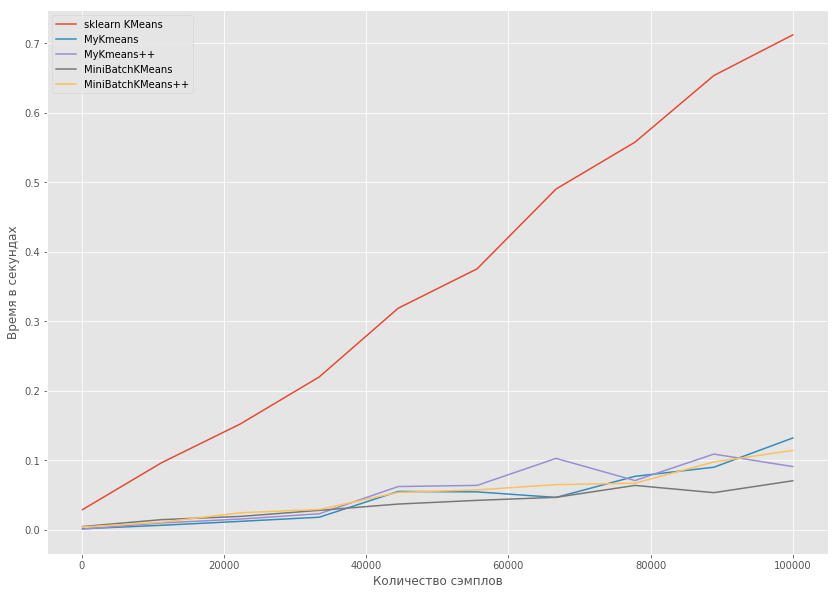

In [17]:
sizes = np.linspace(100, 100000, 10, dtype=int)
models = [(KMeans(n_clusters=3, max_iter=100), 'sklearn KMeans'),
          (MyKmeans(k=3, max_iter=100), 'MyKmeans'),
          (MyKmeans(k=3, init='k-means++', max_iter=100), 'MyKmeans++'),
          (MiniBatchKMeans(k=3, n_batches=10, max_iter=100),
          'MiniBatchKMeans'),
          (MiniBatchKMeans(k=3, init='k-means++', n_batches=10, max_iter=100),
          'MiniBatchKMeans++')]
records = np.empty((len(models), sizes.shape[0]))

for j, k in enumerate(sizes):
    X, _ = make_blobs(n_samples=k, n_features=2, centers=3,
                      cluster_std=1, shuffle=True, random_state=1234)

    for i, model in enumerate(models):
        start = timer()
        model[0].fit(X)
        records[i][j] = timer() - start

for i, model in enumerate(models):
    plt.plot(sizes, records[i], label=model[1])

plt.xlabel(u'Количество сэмплов')
plt.ylabel(u'Время в секундах')
plt.legend()
plt.show()


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [18]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [19]:
df = df_sns.drop(labels=df_sns.columns[:4], axis=1)
X = df.values
X = (X - X.mean(axis=0)) / X.std(axis=0)


In [20]:
def analyse_model(model):
    model.fit(X)
    print u'\tТоп-7 слов из каждого кластера:'
    for i in xrange(9):
        print u'Кластер №{}\n  размер: {}\n  топ слова: {}'\
            .format(i + 1, X[model.labels == i].shape[0],
                    ', '.join(df.columns[X[model.labels == i]
                              .sum(axis=0).argsort()[-7:][::-1]].values))


In [21]:
# MyKMeans
analyse_model(MyKmeans(k=9))


	Топ-7 слов из каждого кластера:
Кластер №1
  размер: 832
  топ слова: hollister, abercrombie, shopping, mall, clothes, hair, hot
Кластер №2
  размер: 765
  топ слова: marching, band, music, rock, football, god, dance
Кластер №3
  размер: 19352
  топ слова: blonde, tennis, soccer, jesus, bible, drunk, sex
Кластер №4
  размер: 941
  топ слова: death, die, rock, god, music, drunk, hair
Кластер №5
  размер: 833
  топ слова: cheerleading, baseball, football, rock, basketball, shopping, cute
Кластер №6
  размер: 4068
  топ слова: shopping, cute, mall, dress, dance, hot, clothes
Кластер №7
  размер: 816
  топ слова: kissed, drugs, hair, sex, drunk, die, music
Кластер №8
  размер: 1892
  топ слова: softball, volleyball, basketball, sports, football, soccer, baseball
Кластер №9
  размер: 501
  топ слова: bible, jesus, god, church, music, die, death


### Анализ MyKmeans:
1. Девушки
2. Парни
3. Слишком большой кластер
4. Рокеры
5. Спортсмены
6. Девушки (скорее всего, 1 и 6 должны быть единым кластером)
7. Рокеры (скорее всего, 4 и 7 должны быть единым кластером)
8. Спортсмены (скорее всего, 5 и 8 должны быть единым кластером)
9. Верующие

In [22]:
# MyKMeans++
analyse_model(MyKmeans(k=9, init='k_means++'))


	Топ-7 слов из каждого кластера:
Кластер №1
  размер: 536
  топ слова: sexy, cute, sex, hair, drunk, rock, hot
Кластер №2
  размер: 663
  топ слова: marching, band, bible, jesus, god, music, rock
Кластер №3
  размер: 2673
  топ слова: basketball, football, softball, sports, volleyball, soccer, baseball
Кластер №4
  размер: 20374
  топ слова: blonde, bible, jesus, death, god, drunk, die
Кластер №5
  размер: 242
  топ слова: tennis, sports, soccer, church, basketball, shopping, swimming
Кластер №6
  размер: 3127
  топ слова: shopping, hollister, abercrombie, mall, cute, dress, dance
Кластер №7
  размер: 929
  топ слова: kissed, drugs, hair, sex, drunk, die, clothes
Кластер №8
  размер: 656
  топ слова: cheerleading, shopping, football, hollister, abercrombie, cute, mall
Кластер №9
  размер: 800
  топ слова: hot, baseball, football, cute, mall, basketball, rock


### Анализ MyKmeans++:
1. Возможно, рокеры
2. Верующие и чуть увлекаются музыкой :)
3. Увлекаются спортом
4. Слишком большой кластер
5. Увлекаются спортом (но кластер маловат, наверно, его следует объединить с 3)
6. Девушки
7. Испорченные девушки, наверно :)
8. Девушки (скорее всего, 6 и 8 должны быть единым кластером)
9. Не понятно

In [23]:
# MyKMeans с MiniBatchMyKMeans
analyse_model(MiniBatchKMeans(k=9, n_batches=10))


	Топ-7 слов из каждого кластера:
Кластер №1
  размер: 21095
  топ слова: tennis, bible, blonde, jesus, marching, god, band
Кластер №2
  размер: 417
  топ слова: soccer, football, rock, sports, basketball, shopping, music
Кластер №3
  размер: 1835
  топ слова: mall, cute, cheerleading, shopping, clothes, church, hair
Кластер №4
  размер: 39
  топ слова: die, death, god, kissed, jesus, hair, clothes
Кластер №5
  размер: 472
  топ слова: sports, softball, drugs, volleyball, dress, hair, basketball
Кластер №6
  размер: 1168
  топ слова: basketball, football, baseball, sports, volleyball, softball, church
Кластер №7
  размер: 375
  топ слова: dance, rock, music, die, dress, cute, hair
Кластер №8
  размер: 39
  топ слова: sexy, band, cute, sex, die, rock, death
Кластер №9
  размер: 4560
  топ слова: clothes, shopping, hot, rock, abercrombie, hollister, hair


### Анализ MiniBatchMyKmeans:
1. Слишком большой кластер
2. Непонятные спортсмены
3. Девушки
4. Верующие
5. Странные спортсмены
6. Нормальные спортсмены
7. Увлекаются музыкой
8. Рокеры
9. Девушки

In [24]:
# MyKMeans++ с MiniBatchMyKMeans
analyse_model(MiniBatchKMeans(k=9, n_batches=10, init='k_means++'))


	Топ-7 слов из каждого кластера:
Кластер №1
  размер: 1614
  топ слова: drunk, kissed, drugs, hair, sex, die, dance
Кластер №2
  размер: 462
  топ слова: hollister, abercrombie, shopping, dress, clothes, mall, soccer
Кластер №3
  размер: 23694
  топ слова: blonde, cheerleading, volleyball, jesus, bible, soccer, sexy
Кластер №4
  размер: 929
  топ слова: marching, band, dance, music, church, dress, shopping
Кластер №5
  размер: 29
  топ слова: sex, kissed, hair, blonde, drunk, music, drugs
Кластер №6
  размер: 2568
  топ слова: rock, music, sports, hair, football, baseball, clothes
Кластер №7
  размер: 530
  топ слова: basketball, god, die, jesus, bible, church, death
Кластер №8
  размер: 100
  топ слова: swimming, kissed, hair, clothes, abercrombie, drugs, music
Кластер №9
  размер: 74
  топ слова: softball, basketball, sports, volleyball, sex, clothes, kissed


### Анализ MiniBatchMyKmeans++:
1. Люди, живущие полной жизнью :)
2. Девушки
3. Слишком большой кластер
4. Увлекаются музыкой
5. Скорее, часть первого кластера
6. Парни, наверно
7. Верующие ~~баскетболисты~~
8. Девушки, наверно (кластер маловат, возможно, в этом проблема)
9. Спортсмены

## Вывод
Не могу выделить явного лидера. У обычной версии (не ++) есть недостаток: при случайном первом приближении центроидов иногда явно единый кластер делится на два, а того гляди и на 3. MiniBatch версия работает быстрее обычного алгоритма (при большом объеме данных, в данном случае разница не видна) (за счет более быстрого обновления центроидов по батчам, а не по всему набору данных), а результаты похожи, так что, думаю, следует отдавать предпочтение MiniBatchKMeans. Но при этом в этой версии алгоритма нужно подбирать еще один гиперпараметр, что, конечно, осложняет дело. В результате работы KMeans++ алгоритма получилось больше маленьких кластеров, но зато они отличаются от остальных. Это говорит о том, что KMeans++ лучше нашел различные кластера, за что можно сказать спасибо усложненной инициализации начального приближения для центроидов.